In [1]:
# Standard definitions needed for script
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
import math
from astropy.table import Table
from astropy.io import fits
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from numpy.polynomial.polynomial import polyfit
import astropy.constants as const
from astropy.coordinates import Angle
import pickle
import pandas as pd
from matplotlib.patches import Rectangle
from sklearn.cluster import KMeans
%matplotlib inline

# Read in Data and Cross Match

In [2]:
file = 'Data/GAIA_data2.pkl'
with open(file,'rb') as f: 
    data = pickle.load(f)
GTab = data['GTab']

print (GTab.colnames)
Gra = GTab["ra"]
Gdec = GTab["dec"]
Gpmra = GTab["pmra"]
Gpmra_e = GTab["pmra_error"]
Gpmdec = GTab["pmdec"]
Gpmdec_e = GTab["pmdec_error"]
Gpar = GTab["parallax"]
Gpar_sn = GTab["parallax_over_error"]
Gsepar = GTab["angular_distance"]
G2MASS = GTab["designation_2"]
g = GTab["phot_g_mean_mag"]
b = GTab["phot_bp_mean_mag"]
r = GTab["phot_rp_mean_mag"]
J = GTab["j_m"]
H = GTab["h_m"]
K = GTab["ks_m"]
print(" GAIA Table contains ",len(Gra)," sources")

#calculate distance in pc and proper motion in km/s
Gdist = 1000./Gpar
Gpmra_km = (Gpmra*Gdist*const.au.value)/(u.yr.to('s')*1000.)/1000.
Gpmdec_km = (Gpmdec*Gdist*const.au.value)/(u.yr.to('s')*1000.)/1000.


#add variables to an array
Gvalues = Gra,Gdec,Gpmra,Gpmdec,Gpar,Gpar_sn,Gdist,Gpmra_km,Gpmdec_km

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_erro

In [3]:
#creates list of indentifiers from 2MASS? 

gaia_list = []
for i in range(0,len(G2MASS)):
    gaia_list.append(G2MASS[i].decode('utf-8'))

In [4]:
#read in gould belt YSO catalog

infile = "Data/SERAQU-YSOs.tbl"
GBYSO = Table.read(infile,format="ascii.ipac")
print(GBYSO.colnames)
GBYSOra = GBYSO["ra"]
GBYSOdec = GBYSO["dec"]
GBYSO2MASS = GBYSO["id2mass"]
print("Read ",len(GBYSOra)," YSOs from GB YSO catalog")

#match up GAIA catalog and Gould Belt YSO
GBYSO_match = np.empty(len(GBYSO2MASS),dtype=int); GBYSO_match.fill(-2)
for j in range(0,len(GBYSO2MASS)):
    if(GBYSO2MASS[j] in gaia_list):
        GBYSO_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

['GBS_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

In [5]:
#read in gould belt stars + dust catalgog

infile = "Data/SERP_GB_star+dust.tbl"
GBSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
GBSDra = GBSD["ra"]
GBSDdec = GBSD["dec"]
GBSD2MASS = GBSD["id2mass"]
print("Read ",len(GBSDra)," YSOs from GB Star+Dust catalog")

#match up GAIA catalog and Gould Belt stars+dust
GBSD_match = np.empty(len(GBSD2MASS),dtype=int); GBSD_match.fill(-2)
for j in range(0,len(GBSD2MASS)):
    if(GBSD2MASS[j] in gaia_list):
        GBSD_match[j] = gaia_list.index(GBSD2MASS[j])
    else:
        GBSD_match[j] = -2
good_GBSD = GBSD_match > -1
print(len(GBSD_match[good_GBSD]))
print(np.where(GBSD_match > -1))

Read  3725  YSOs from GB Star+Dust catalog
97
(array([ 690,  744,  749,  850,  891,  893,  949,  989, 1170, 1185, 1213,
       1280, 1291, 1311, 1336, 1400, 1401, 1414, 1437, 1470, 1506, 1583,
       1627, 1721, 1764, 1781, 1793, 1799, 1880, 1907, 1956, 2005, 2079,
       2107, 2178, 2186, 2188, 2194, 2212, 2219, 2223, 2226, 2233, 2254,
       2304, 2330, 2572, 2615, 2642, 2751, 2752, 2859, 2902, 2920, 2956,
       3084, 3119, 3127, 3129, 3133, 3136, 3138, 3170, 3175, 3213, 3267,
       3271, 3287, 3304, 3310, 3326, 3330, 3344, 3346, 3366, 3369, 3372,
       3375, 3380, 3406, 3417, 3435, 3465, 3478, 3480, 3488, 3489, 3494,
       3501, 3512, 3521, 3530, 3542, 3549, 3625, 3697, 3719]),)


In [6]:
#read in c2d YSO catalog 

infile = "Data/catalog-SER-YSOc.tbl"
c2dYSO = Table.read(infile,format="ascii.ipac")
print(c2dYSO.colnames)
c2dYSOra = c2dYSO["ra"]
c2dYSOdec = c2dYSO["dec"]
c2dYSO2MASS = c2dYSO["id2mass"]
c2dYSOobj = c2dYSO["object_type"]
print("Read ",len(c2dYSOra)," YSOs from c2d YSO catalog")

#match up GAIA catalog and c2d YSO catalog
c2dYSO_match = np.empty(len(c2dYSO2MASS),dtype=int); c2dYSO_match.fill(-2)
for j in range(0,len(c2dYSO2MASS)):
    if(c2dYSO2MASS[j] in gaia_list):
        c2dYSO_match[j] = gaia_list.index(c2dYSO2MASS[j])
    else:
        c2dYSO_match[j] = -2
good_c2dYSO = c2dYSO_match > -1
print(len(c2dYSO_match[good_c2dYSO]))
print(np.where(c2dYSO_match > -1))

['c2d_ID', 'ra', 'D_ra', 'dec', 'D_dec', 'Q_pos', 'Q_merge', 'id2mass', 'Prob_Galc', 'alpha', 'D_alpha', 'alpha_chi2', 'alpha_nfit', 'object_type', 'Av', 'D_Av', 'mag_IR1', 'D_mag_IR1', 'Av_chi2', 'Av_nfit', 'J_flux_c', 'J_D_flux_c', 'J_date_c', 'J_Q_det_c', 'H_flux_c', 'H_D_flux_c', 'H_date_c', 'H_Q_det_c', 'Ks_flux_c', 'Ks_D_flux_c', 'Ks_date_c', 'Ks_Q_det_c', 'IR1_flux_1', 'IR1_D_flux_1', 'IR1_date_1', 'IR1_Q_det_1', 'IR1_flux_2', 'IR1_D_flux_2', 'IR1_date_2', 'IR1_Q_det_2', 'IR1_flux_c', 'IR1_D_flux_c', 'IR1_date_c', 'IR1_Q_det_c', 'IR1_Q_flux_m', 'IR1_imtype', 'IR1_src_area', 'IR1_amajor', 'IR1_aminor', 'IR1_tilt', 'IR2_flux_1', 'IR2_D_flux_1', 'IR2_date_1', 'IR2_Q_det_1', 'IR2_flux_2', 'IR2_D_flux_2', 'IR2_date_2', 'IR2_Q_det_2', 'IR2_flux_c', 'IR2_D_flux_c', 'IR2_date_c', 'IR2_Q_det_c', 'IR2_Q_flux_m', 'IR2_imtype', 'IR2_src_area', 'IR2_amajor', 'IR2_aminor', 'IR2_tilt', 'IR3_flux_1', 'IR3_D_flux_1', 'IR3_date_1', 'IR3_Q_det_1', 'IR3_flux_2', 'IR3_D_flux_2', 'IR3_date_2', 'IR3_Q

In [7]:
#read in c2d YSO stars+dust catalog

infile = "Data/SERP_c2d_star+dust.tbl"
c2dSD = Table.read(infile,format="ascii.ipac")
# print(GBSD.colnames)
c2dSDra = c2dSD["ra"]
c2dSDdec = c2dSD["dec"]
c2dSD2MASS = c2dSD["id2mass"]
print("Read ",len(c2dSDra)," YSOs from c2d Star+Dust catalog")

#match up GAIA catalog and c2d YSO catalog
c2dSD_match = np.empty(len(c2dSD2MASS),dtype=int); c2dSD_match.fill(-2)
for j in range(0,len(c2dSD2MASS)):
    if(c2dSD2MASS[j] in gaia_list):
        c2dSD_match[j] = gaia_list.index(c2dSD2MASS[j])
    else:
        c2dSD_match[j] = -2
good_c2dSD = c2dSD_match > -1
print(len(c2dSD_match[good_c2dSD]))
print(np.where(c2dSD_match > -1))

Read  256  YSOs from c2d Star+Dust catalog
24
(array([  2,  29,  51,  54, 126, 128, 142, 147, 153, 156, 171, 175, 191,
       193, 201, 214, 217, 219, 223, 224, 228, 235, 238, 251]),)


# Analyze Data

In [8]:
#total number of YSO matches

#YSO matches
YSO_match = c2dYSO_match; YSO_match = np.append(YSO_match,GBYSO_match)
good_YSO = YSO_match > -1
print("Total number of GAIA matches to YSOs: ",len(YSO_match[good_YSO]))

#Star + Dust matches
SD_match = c2dSD_match; SD_match = np.append(SD_match,GBSD_match)
good_SD = SD_match > -1
print("Total number of GAIA matches to star+dust: ",len(SD_match[good_SD]))

#All YSO matches
ALL_match = YSO_match
ALL_match = np.append(ALL_match,SD_match)
good_ALL = ALL_match > -1
print("Total number of all matches: ",len(ALL_match[good_ALL]))

Total number of GAIA matches to YSOs:  195
Total number of GAIA matches to star+dust:  121
Total number of all matches:  316


In [9]:
#Coordinates that indicate regions

#region 1
ra_min1 = 279
ra_max1 = 280.1
dec_min1 = -1
dec_max1 = 1
width1 = (ra_max1-ra_min1)
height1 = (dec_max1 - dec_min1)

sky_region1 = [ra_min1,ra_max1,dec_min1,dec_max1]

#region 2
ra_min2 = 276.5
ra_max2 = 278.5
dec_min2 = -4.25
dec_max2 = -1.75
width2 = (ra_max2-ra_min2)
height2 = (dec_max2 - dec_min2)

sky_region2 = [ra_min2,ra_max2,dec_min2,dec_max2]

#W40: part of region 2
ra_minW40 = 276.5
ra_maxW40 = 278.5
dec_minW40 = -3.0
dec_maxW40 = -1.75
widthW40 = (ra_maxW40-ra_minW40)
heightW40 = (dec_maxW40-dec_minW40)

sky_regionW40 = [ra_minW40,ra_maxW40,dec_minW40,dec_maxW40]

#region 3
ra_min3 = 276.75
ra_max3 = 277.75
dec_min3 = -1
dec_max3 = 2
width3 = (ra_max3-ra_min3)
height3 = (dec_max3 - dec_min3)

sky_region3 = [ra_min3,ra_max3,dec_min3,dec_max3]

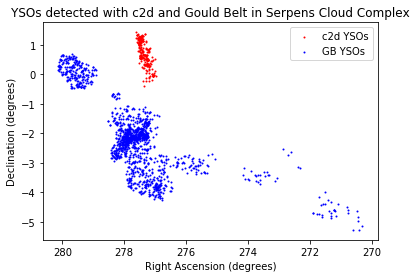

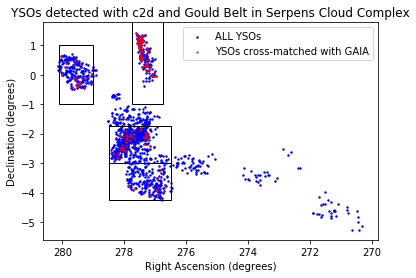

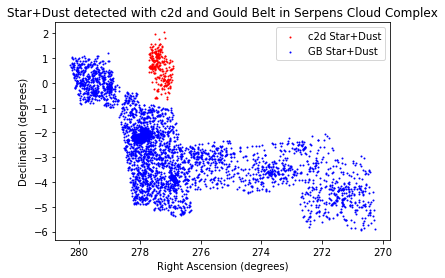

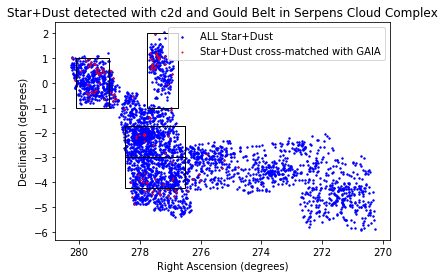

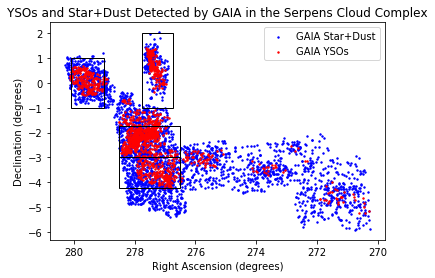

In [10]:
#combine ra and dec for all YSOs into an array for ra and an array for dec
c2dYSOra_data = np.array(c2dYSOra.data)
c2dYSOdec_data = np.array(c2dYSOdec.data)
GBYSOra_data = np.array(GBYSOra.data)
GBYSOdec_data = np.array(GBYSOdec.data)
YSO_ra = c2dYSOra_data; YSO_ra = np.append(YSO_ra,GBYSOra_data)
YSO_dec = c2dYSOdec_data; YSO_dec = np.append(YSO_dec,GBYSOdec_data)

#combine ra and dec for all star+dust into an array for ra and an array for dec
c2dSDra_data = np.array(c2dSDra.data)
c2dSDdec_data = np.array(c2dSDdec.data)
GBSDra_data = np.array(GBSDra.data)
GBSDdec_data = np.array(GBSDdec.data)
SD_ra = c2dSDra_data; SD_ra = np.append(SD_ra,GBSDra_data)
SD_dec = c2dSDdec_data; SD_dec = np.append(SD_dec,GBSDdec_data)

#combine ra and dec for all 


#Plot of c2d and Gould Belt YSOs
figure = plt.figure()
plt.scatter(c2dYSOra_data,c2dYSOdec_data,c='r',label = 'c2d YSOs',s=1)
plt.scatter(GBYSOra_data,GBYSOdec_data,c='b',label = 'GB YSOs',s=1)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.show()

#Plot of matched YSOs and all YSOs
figure = plt.figure()
plt.scatter(YSO_ra,YSO_dec,c='b',s=2,label='ALL YSOs')
plt.scatter(YSO_ra[YSO_match >-1],YSO_dec[YSO_match >-1],c='r',s=1,label='YSOs cross-matched with GAIA')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_min2,dec_min2),width2,height2,fill=False))
plt.gca().add_patch(Rectangle((ra_min3,dec_min3),width3,height3,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/YSO_plot.png')
plt.show()

#Plot of c2d and Gould Belt star+dust
figure = plt.figure()
plt.scatter(c2dSDra_data,c2dSDdec_data,c='r',label = 'c2d Star+Dust',s=1)
plt.scatter(GBSDra_data,GBSDdec_data,c='b',label = 'GB Star+Dust',s=1)
plt.gca().invert_xaxis()
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Star+Dust detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.show()

#Plot of matched star+dust and all star+dust
figure = plt.figure()
plt.scatter(SD_ra,SD_dec,c='b',s=2,label='ALL Star+Dust')
plt.scatter(SD_ra[SD_match >-1],SD_dec[SD_match >-1],c='r',s=1,label='Star+Dust cross-matched with GAIA')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('Star+Dust detected with c2d and Gould Belt in Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_min2,dec_min2),width2,height2,fill=False))
plt.gca().add_patch(Rectangle((ra_min3,dec_min3),width3,height3,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/Star+Dust_plot.png')
plt.show()

#Plot of YSOs and star +dust in GAIA
figure = plt.figure()
plt.scatter(SD_ra,SD_dec,c='b',s=2,label='GAIA Star+Dust')
plt.scatter(YSO_ra,YSO_dec,c='r',s=2,label='GAIA YSOs')
plt.xlabel('Right Ascension (degrees)')
plt.ylabel('Declination (degrees)')
plt.title('YSOs and Star+Dust Detected by GAIA in the Serpens Cloud Complex')
plt.legend()
plt.gca().add_patch(Rectangle((ra_min1,dec_min1),width1,height1,fill=False))
plt.gca().add_patch(Rectangle((ra_min2,dec_min2),width2,height2,fill=False))
plt.gca().add_patch(Rectangle((ra_min3,dec_min3),width3,height3,fill=False))
plt.gca().add_patch(Rectangle((ra_minW40,dec_minW40),widthW40,heightW40,fill=False))
plt.gca().invert_xaxis()
plt.savefig('Figures/YSO_SD_plot.png')
plt.show()

#Do the distances need to be filtered? 

In [11]:
#Function to calculate the properties of region of YSOs that have been cross matched with GAIA, 
def CalculateProperties(star_type,match,Gvalues,distance_range = [0.,630.],sky_region = [273.99,280.99,-5.,2.]):
    
    #create arrays with information about the data
    good_match = match > -1
    identifiers = np.array([])
    ra_match = np.array([])
    dec_match = np.array([])
    pmra_match = np.array([])
    pmdec_match = np.array([])
    pmra_e_match = np.array([])
    pmdec_e_match = np.array([])
    par_match = np.array([])
    par_sn_match = np.array([])
    dist_match = np.array([])
    pmra_km_match = np.array([])
    pmdec_km_match = np.array([])
    n = 0
    
    #find number of _match matches in the distance correct interval
    for i in range(0,len(match)):
        if(match[i] > -1):
            j = match[i]
            #Filter values according to distance and region in the sky
            if(Gvalues[6][j] >= distance_range[0] and Gvalues[6][j] <= distance_range[1] \
                and Gvalues[0][j] >= sky_region[0] and Gvalues[1][j] <= sky_region[1] \
                and Gvalues[1][j] >= sky_region[2] and Gvalues[1][j] <= sky_region[3]):
                    identifiers = np.append(identifiers,j)
                    ra_match = np.append(ra_match,Gvalues[0][j])
                    dec_match = np.append(dec_match,Gvalues[1][j])
                    pmra_match = np.append(pmra_match,Gvalues[2][j])
                    pmdec_match = np.append(pmdec_match,Gvalues[3][j])
                    par_match = np.append(par_match,Gvalues[4][j])
                    par_sn_match = np.append(par_sn_match,Gvalues[5][j])
                    dist_match = np.append(dist_match,Gvalues[6][j])
                    pmra_km_match = np.append(pmra_km_match,Gvalues[7][j])
                    pmdec_km_match = np.append(pmdec_km_match,Gvalues[8][j])
                    n=n+1
    print("Number of "+ star_type +" matches in the correct distance interval:",n)
    
    #find number of match within parallax S/N greater than certain amount
    parsn10 = par_sn_match > 10.
    parsn5 = par_sn_match > 5
    parsn20 = par_sn_match > 20
    print("Number of _match with parallax > 5, 10, 20: ", \
          len(par_sn_match[parsn5]),len(par_sn_match[parsn10]),len(par_sn_match[parsn20]))

    #scatter plot of ra and dec
    plt.scatter(ra_match[parsn5],dec_match[parsn5],s=5)
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Coordinates of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    #scatter plot of proper motions
    plt.scatter(pmra_match[parsn5],pmdec_match[parsn5],s=5)
    plt.xlabel('Proper motion in Right Ascension (mas/s)')
    plt.ylabel('Proper motion in Declination (mas/s)')
    plt.title('Proper Motions of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    #scatter plot of proper motions (km/s)
    plt.scatter(pmra_km_match[parsn5],pmdec_km_match[parsn5],s=5)
    plt.xlabel('Proper motion in Right Ascension (km/s)')
    plt.ylabel('Proper motion in Declination (km/s)')
    plt.title('Proper Motions of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    #plot of matches at ra and dec with proper motions
    plt.quiver(ra_match[parsn5],dec_match[parsn5],pmra_km_match[parsn5],pmdec_km_match[parsn5])
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Proper Motions of '+star_type)
    plt.gca().invert_xaxis()
    plt.show()
    
    #mean proper motions (changed to km/s)
    mean_pmra = np.mean(pmra_km_match[parsn10])
    mean_pmdec = np.mean(pmdec_km_match[parsn10])
    print("Mean proper motion (Ra,Dec): ",mean_pmra,mean_pmdec)
    #median proper motions
    median_pmra = np.median(pmra_km_match[parsn10])
    median_pmdec = np.median(pmdec_km_match[parsn10])
    print("Median proper motion (Ra,Dec): ",median_pmra,median_pmdec)
    #deviation from median of proper motion  of S/N > 10 _matchs
    rpmra_match = pmra_km_match - median_pmra
    rpmdec_match = pmdec_km_match - median_pmdec
    #magnitude of deviation from median of proper motion
    pmmag_match = np.zeros(len(match[good_match]))
    pmmag_match = np.power((rpmra_match*rpmra_match+rpmdec_match*rpmdec_match),0.5)
    
    #Calculate difference of point from centroid
    
    #histogram of pmra, pmdec, pmmag, rpmra, rpmdec, pmmag_dev, pmra_std, pmdec_std, pmmag_std
    plt.hist(pmra_km_match)
    plt.title('Proper Motion in RA')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(pmdec_km_match)
    plt.title('Proper Motion in Dec')
    plt.xlabel('Proper Motion (km/s)')
    plt.show()
    plt.hist(rpmra_match)
    plt.title('Deviation from Median Proper Motion in RA')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(rpmdec_match)
    plt.title('Deviation from Median Proper Motion in Dec')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    plt.hist(pmmag_match,bins=15)
    plt.title('Magnitude of Deviation from Median Proper Motion')
    plt.xlabel('Proper Motion (km/s)')
    plt.ylabel('Count')
    plt.show()
    
    #plot of matches at ra and dec with deviation from median of proper motion
    plt.quiver(ra_match[parsn5],dec_match[parsn5],rpmra_match[parsn5],rpmdec_match[parsn5],pmmag_match[parsn5])
    plt.xlabel('Right Ascension (Degrees)')
    plt.ylabel('Declination (Degrees)')
    plt.title('Proper Motion Deviation from Median of '+star_type)
    plt.gca().invert_xaxis()
    plt.colorbar()
    plt.show()   
    
    #add all of the calculated values to an array
    result1 = [ra_match, dec_match, pmra_match, pmdec_match, pmra_e_match, pmdec_e_match, \
            par_match, par_sn_match, dist_match, pmra_km_match, pmdec_km_match, \
            rpmra_match,rpmdec_match, pmmag_match,parsn10,parsn5,parsn20, identifiers] #18 arguments
    result2 = mean_pmra,mean_pmdec,median_pmra,median_pmdec
    
    return result1, result2
            

In [12]:
# Routines to convert magnitude to flux and vice versa for various wavebands.
#
# Additional wavebands can be added easily.
# MWP - Fri Jul 20 10:34:24 EDT 2018
#

# Mean wavelengths and effective bandwidths in micron & Zero Points in Jansky of various filters, 
# taken from VOSA website.  # http://svo2.cab.inta-csic.es/theory/fps/
# Format is dictionary of tuples:
#  {'Bandname':(Lambda_mean,BW_eff, ZP)}
#
sloan    = {'u':(3561.8,558.4,1568.5),'g':(4718.9,1158.4,3965.9),'r':(6185.2,1111.2,3162.0),'i':(7499.7,1044.6,2602.0),'z':(8961.5,1124.6,2244.7)}
# Gaia 2nd Release (GAIA2r) values
gaia    = {'BP':(5278.6,2279.4,3393.3),'G':(6773.7,4358.4,2835.1),'RP':(7919.1,2943.7,2485.1)}
twomass = {'J':(12350.0,1624.1,1594.0), 'H':(16620.0, 2509.4,1024.0), 'K':(21590.0,2618.9,666.8)}
spitzer = {'I1':(35572.6,6836.2,277.2), 'I2':(45049.3,8649.9,179.0), 'I3':(57385.7,12561.2,113.8), 'I4':(79273.7,25288.5,62.0), 'M24':(238433.1,52963.2,7.1), 'M70':(725555.3,213015.3,0.8), 'M160':(1569627.1,357530.2,0.2)}
herschel = {'PACSB':(719334.2,214148.9,0.8),'PACSG':(1026174.6,312860.0,0.4),'PACSR':(1671355.3,697595.3,0.1)}
#
# All filters -- Dictionary of dictionaries
#
filters = { "sloan": sloan, "gaia" : gaia, "twomass":twomass, "spitzer": spitzer, "herschel": herschel}

# Return given (milli)jansky
# Example: magtoflux("sloan","u",10)  returns 156.85 mJy 
def magtoflux(telescope,filter,magnitude,mjy=True):
    """Return the flux in Jansky or milliJansky of a source given its magnitude.
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          magnitude - magnitude of source
          mjy       - boolean to return flux in mJy. True returns mJy, False returns Jy. Default:True
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: zpjy *= 1000.0
    return zpjy*10.0**(magnitude/-2.5)

# Return magnitude given jansky
# @todo allow mJy input as well
# Requires "import numpy as np"
# Example: fluxtomag("sloan","u",156.85)  returns 10 mag
def fluxtomag(telescope,filter,flux,mjy=True):
    """Return the magnitude given flux in Jansky
       Parameters:
          telescope - string telescope name lowercase, one of
                      sloan, gaia, twomass, spitzer, herschel
          filter    - wave band of telescope e.g., 'u' for sloan, 'I1' for spitzer
          flux      - flux of source in Jy or mJy
          mjy       - boolean, True if flux was given in mJy False if Jy
    """
    zpjy = filters[telescope][filter][2]
    if mjy==True: 
        cflux = 0.001
    else: 
        cflux = 1.0
    return -2.5*np.log10(cflux*flux/zpjy)

Number of YSOs matches in the correct distance interval: 147
Number of _match with parallax > 5, 10, 20:  135 86 43


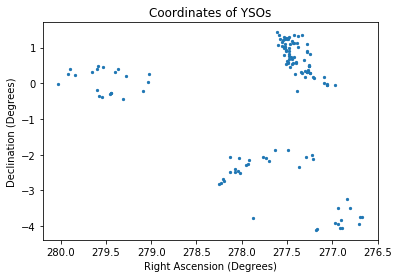

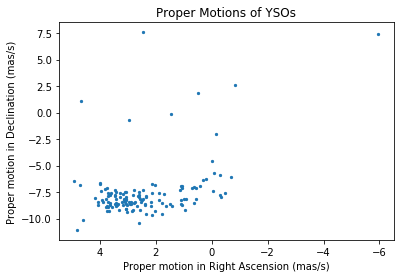

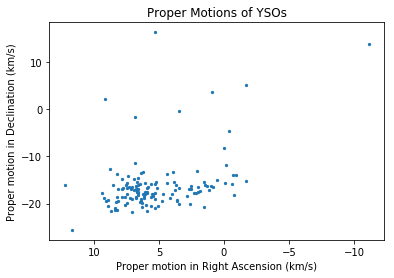

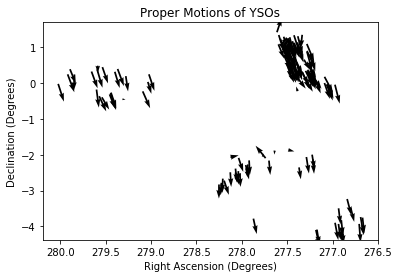

Mean proper motion (Ra,Dec):  5.3667474149 -15.4543655217
Median proper motion (Ra,Dec):  6.15832757507 -17.0584680766


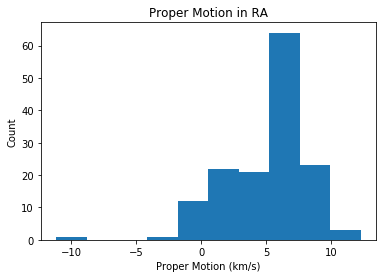

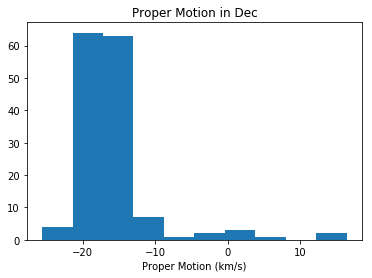

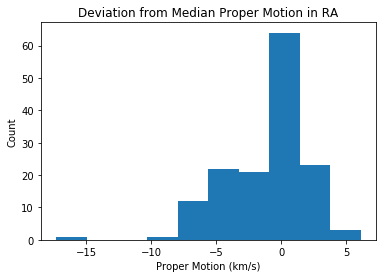

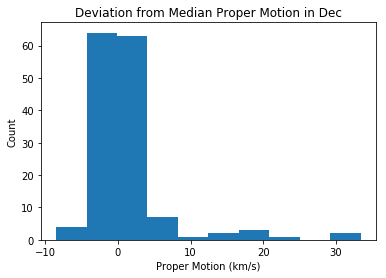

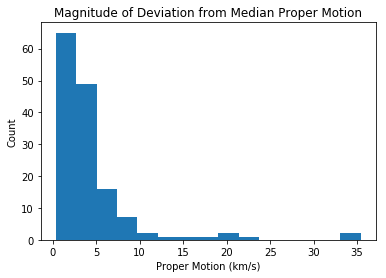

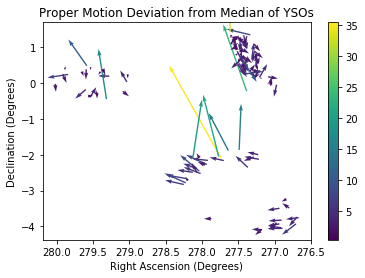

In [14]:
YSO_properties, YSO_values = CalculateProperties('YSOs',YSO_match,Gvalues,distance_range=[350.,550.])

raYSO = YSO_properties[0][:]
decYSO = YSO_properties[1][:]
pmraYSO = YSO_properties[2][:]
pmdecYSO = YSO_properties[3][:]
pmra_eYSO = YSO_properties[4][:]
pmdec_eYSO = YSO_properties[5][:]
parYSO = YSO_properties[6][:]
par_snYSO = YSO_properties[7][:]
distYSO = YSO_properties[8][:]
pmra_kmYSO = YSO_properties[9][:]
pmdec_kmYSO = YSO_properties[10][:]
rpmraYSO = YSO_properties[11][:]
rpmdecYSO = YSO_properties[12][:]
pmmagYSO = YSO_properties[13][:]
parsn10YSO = YSO_properties[14][:]
parsn5YSO = YSO_properties[15][:]
parsn10YSO = YSO_properties[16][:]
mean_pmraYSO = YSO_values[0]
mean_pmdecYSO = YSO_values[1]
median_pmraYSO = YSO_values[2]
median_pmdecYSO = YSO_values[3]

Number of Stars+Dust matches in the correct distance interval: 82
Number of _match with parallax > 5, 10, 20:  65 43 26


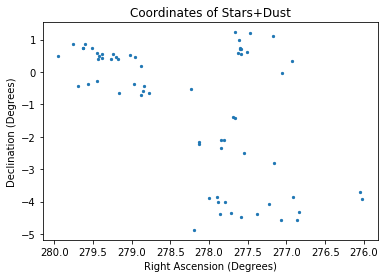

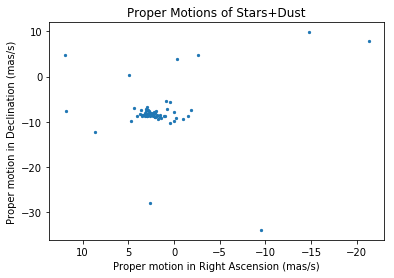

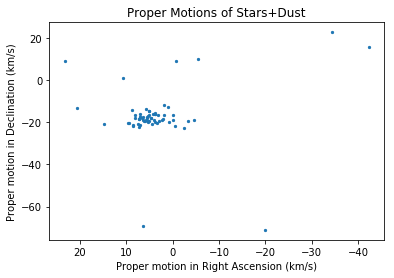

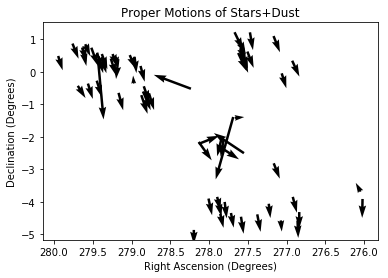

Mean proper motion (Ra,Dec):  3.04455827594 -13.7361372551
Median proper motion (Ra,Dec):  4.7611715435 -17.5411000269


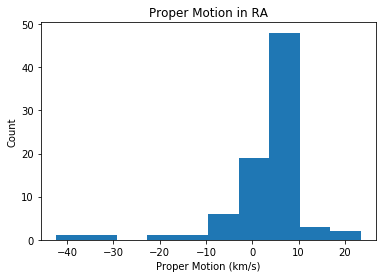

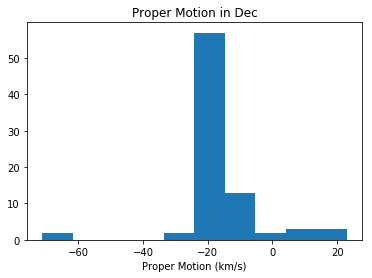

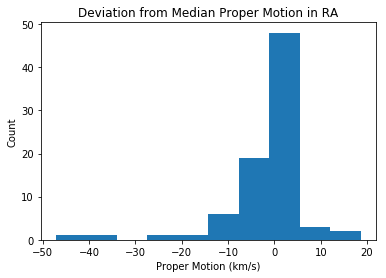

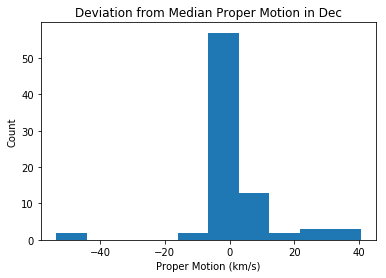

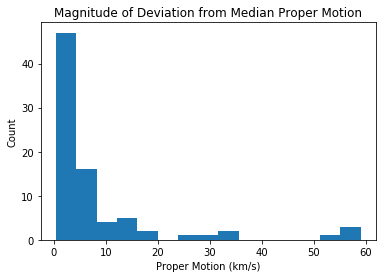

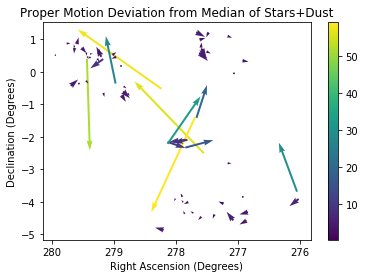

In [15]:
SD_properties, SD_values = CalculateProperties('Stars+Dust',SD_match,Gvalues,distance_range=[350.,550.])

raSD = SD_properties[0][:]
decSD = SD_properties[1][:]
pmraSD = SD_properties[2][:]
pmdecSD = SD_properties[3][:]
pmra_eSD = SD_properties[4][:]
pmdec_eSD = SD_properties[5][:]
parSD = SD_properties[6][:]
par_snSD = SD_properties[7][:]
distSD = SD_properties[8][:]
pmra_kmSD = SD_properties[9][:]
pmdec_kmSD = SD_properties[10][:]
rpmraSD = SD_properties[11][:]
rpmdecSD = SD_properties[12][:]
pmmagSD = SD_properties[13][:]
parsn10SD = SD_properties[14][:]
parsn5SD = SD_properties[15][:]
parsn10SD = SD_properties[16][:]
mean_pmraSD = SD_values[0]
mean_pmdecSD = SD_values[1]
median_pmraSD = SD_values[2]
median_pmdecSD = SD_values[3]

Number of All Sources matches in the correct distance interval: 229
Number of _match with parallax > 5, 10, 20:  200 129 69


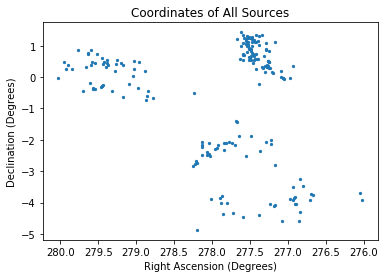

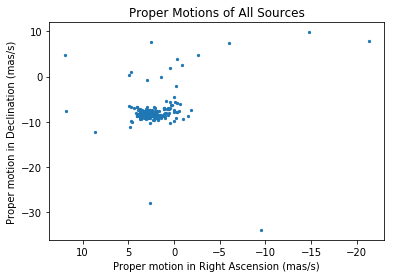

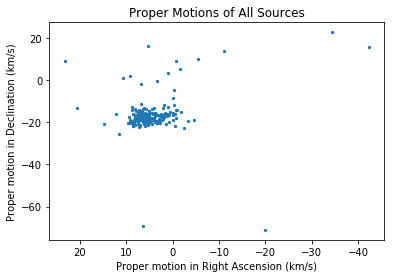

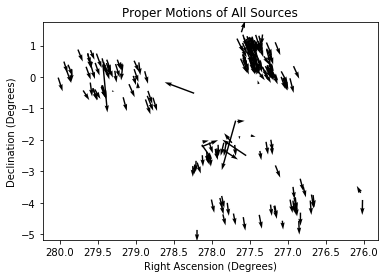

Mean proper motion (Ra,Dec):  4.59268436858 -14.8816227662
Median proper motion (Ra,Dec):  5.90042519817 -17.138520439


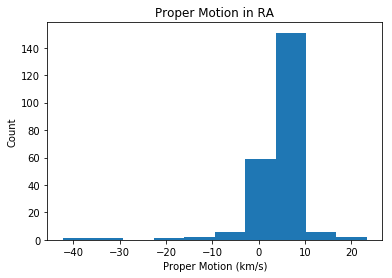

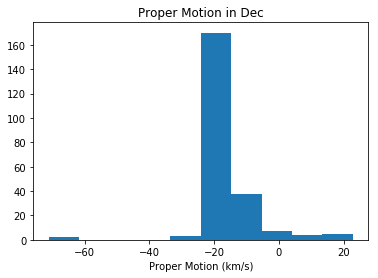

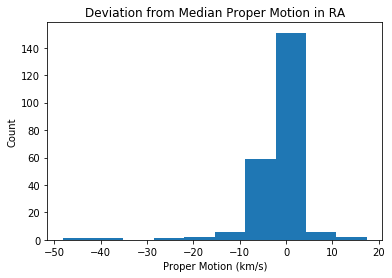

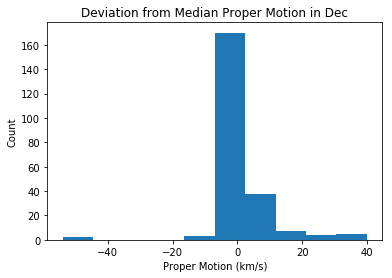

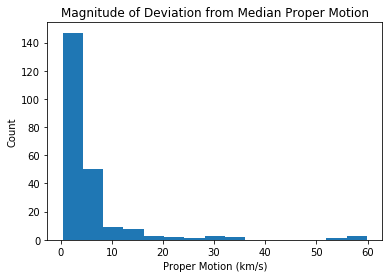

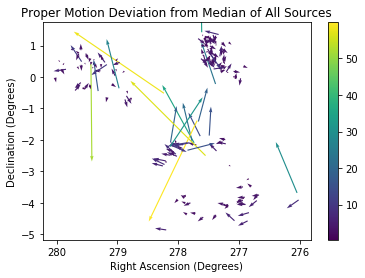

In [16]:
ALL_properties, ALL_values = CalculateProperties('All Sources',ALL_match,Gvalues,distance_range=[350.,550.])

raALL = ALL_properties[0][:]
decALL = ALL_properties[1][:]
pmraALL = ALL_properties[2][:]
pmdecALL = ALL_properties[3][:]
pmra_eALL = ALL_properties[4][:]
pmdec_eALL = ALL_properties[5][:]
parALL = ALL_properties[6][:]
par_snALL = ALL_properties[7][:]
distALL = ALL_properties[8][:]
pmra_kmALL = ALL_properties[9][:]
pmdec_kmALL = ALL_properties[10][:]
rpmraALL = ALL_properties[11][:]
rpmdecALL = ALL_properties[12][:]
pmmagALL = ALL_properties[13][:]
parsn10ALL = ALL_properties[14][:]
parsn5ALL = ALL_properties[15][:]
parsn10ALL = ALL_properties[16][:]
mean_pmraALL = ALL_values[0]
mean_pmdecALL = ALL_values[1]
median_pmraALL = ALL_values[2]
median_pmdecALL = ALL_values[3]

Number of YSO_Reg1 matches in the correct distance interval: 22
Number of _match with parallax > 5, 10, 20:  21 11 6


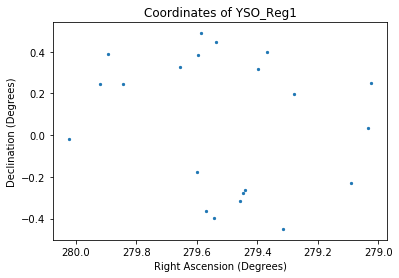

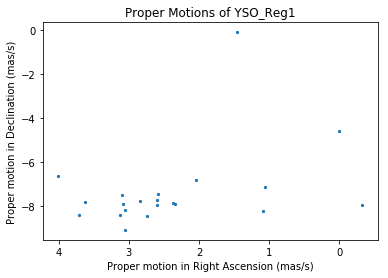

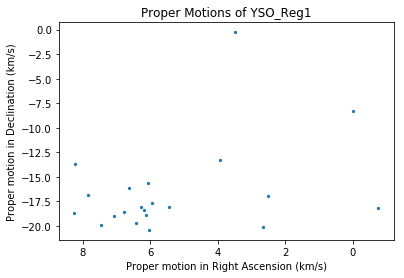

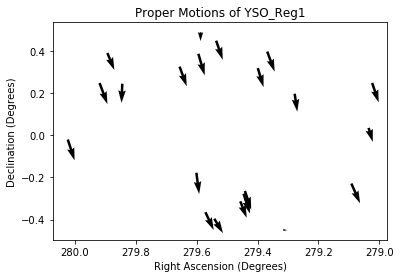

Mean proper motion (Ra,Dec):  6.00959354926 -16.2794521532
Median proper motion (Ra,Dec):  6.1346574026 -18.4214384498


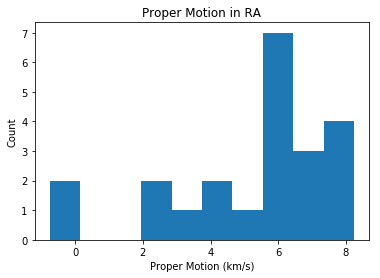

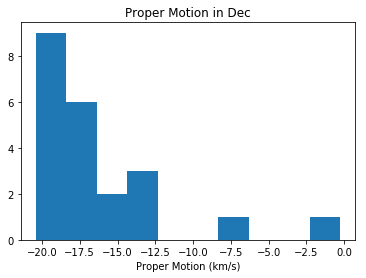

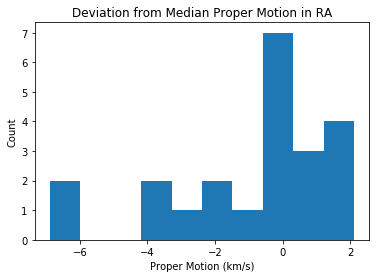

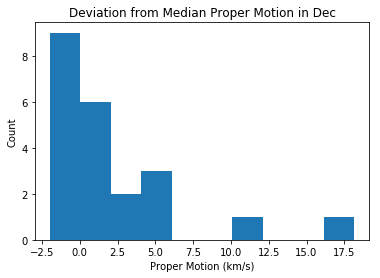

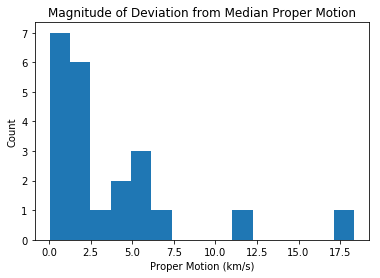

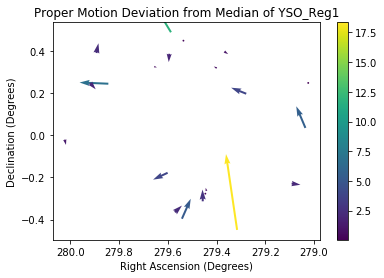

In [17]:
YSO_Reg1_properties, YSO_Reg1_values = CalculateProperties('YSO_Reg1',YSO_match,Gvalues,\
                                                           distance_range=[350.,550.],\
                                                           sky_region = [ra_min1,ra_max1,dec_min1,dec_max1])

raYSO_Reg1 = YSO_Reg1_properties[0][:]
decYSO_Reg1 = YSO_Reg1_properties[1][:]
pmraYSO_Reg1 = YSO_Reg1_properties[2][:]
pmdecYSO_Reg1 = YSO_Reg1_properties[3][:]
pmra_eYSO_Reg1 = YSO_Reg1_properties[4][:]
pmdec_eYSO_Reg1 = YSO_Reg1_properties[5][:]
parYSO_Reg1 = YSO_Reg1_properties[6][:]
par_snYSO_Reg1 = YSO_Reg1_properties[7][:]
distYSO_Reg1 = YSO_Reg1_properties[8][:]
pmra_kmYSO_Reg1 = YSO_Reg1_properties[9][:]
pmdec_kmYSO_Reg1 = YSO_Reg1_properties[10][:]
rpmraYSO_Reg1 = YSO_Reg1_properties[11][:]
rpmdecYSO_Reg1 = YSO_Reg1_properties[12][:]
pmmagYSO_Reg1 = YSO_Reg1_properties[13][:]
parsn10YSO_Reg1 = YSO_Reg1_properties[14][:]
parsn5YSO_Reg1 = YSO_Reg1_properties[15][:]
parsn10YSO_Reg1 = YSO_Reg1_properties[16][:]
mean_pmraYSO_Reg1 = YSO_Reg1_values[0]
mean_pmdecYSO_Reg1 = YSO_Reg1_values[1]
median_pmraYSO_Reg1 = YSO_Reg1_values[2]
median_pmdecYSO_Reg1 = YSO_Reg1_values[3]

Number of YSO_Reg2 matches in the correct distance interval: 44
Number of _match with parallax > 5, 10, 20:  37 22 14


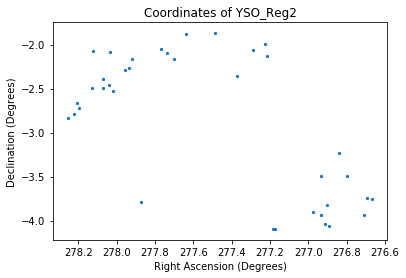

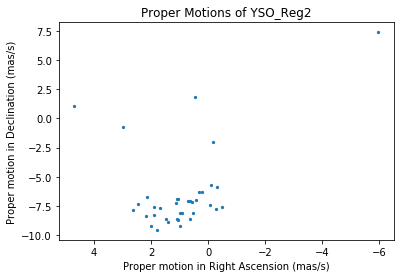

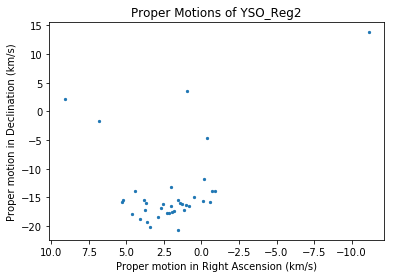

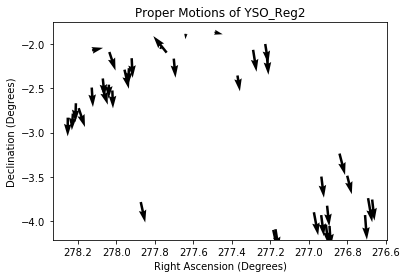

Mean proper motion (Ra,Dec):  2.23925998653 -12.2529753526
Median proper motion (Ra,Dec):  2.15385178379 -16.0919288984


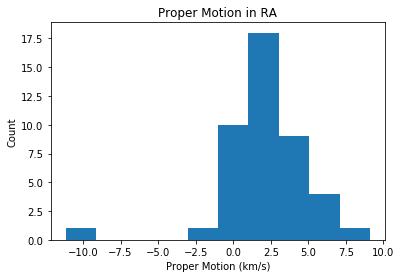

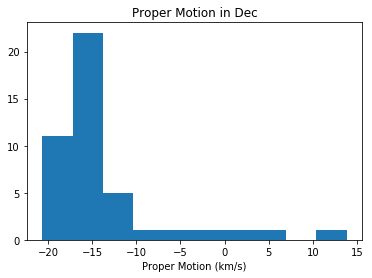

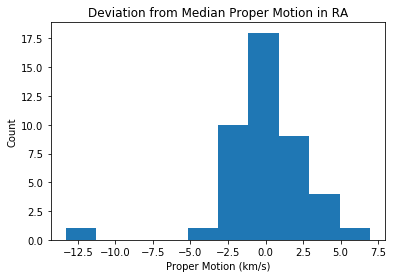

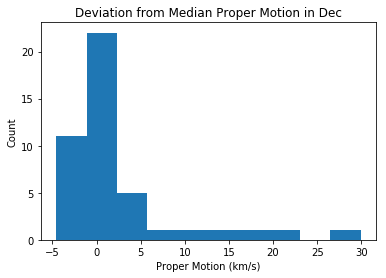

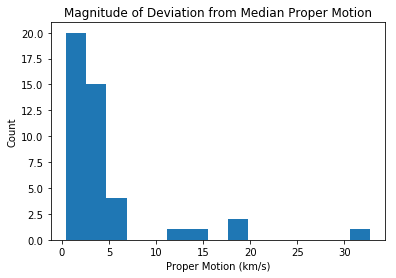

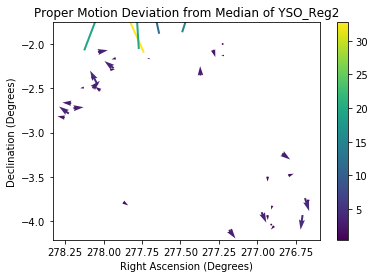

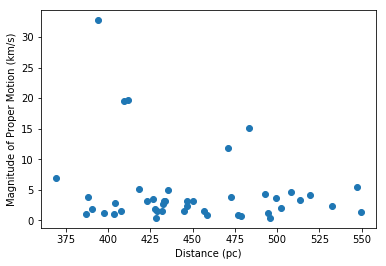

In [18]:
YSO_Reg2_properties, YSO_Reg2_values = CalculateProperties('YSO_Reg2',YSO_match,Gvalues,\
                                                           distance_range=[350.,550.],\
                                                           sky_region = [ra_min2,ra_max2,dec_min2,dec_max2])

raYSO_Reg2 = YSO_Reg2_properties[0][:]
decYSO_Reg2 = YSO_Reg2_properties[1][:]
pmraYSO_Reg2 = YSO_Reg2_properties[2][:]
pmdecYSO_Reg2 = YSO_Reg2_properties[3][:]
pmra_eYSO_Reg2 = YSO_Reg2_properties[4][:]
pmdec_eYSO_Reg2 = YSO_Reg2_properties[5][:]
parYSO_Reg2 = YSO_Reg2_properties[6][:]
par_snYSO_Reg2 = YSO_Reg2_properties[7][:]
distYSO_Reg2 = YSO_Reg2_properties[8][:]
pmra_kmYSO_Reg2 = YSO_Reg2_properties[9][:]
pmdec_kmYSO_Reg2 = YSO_Reg2_properties[10][:]
rpmraYSO_Reg2 = YSO_Reg2_properties[11][:]
rpmdecYSO_Reg2 = YSO_Reg2_properties[12][:]
pmmagYSO_Reg2 = YSO_Reg2_properties[13][:]
parsn10YSO_Reg2 = YSO_Reg2_properties[14][:]
parsn5YSO_Reg2 = YSO_Reg2_properties[15][:]
parsn10YSO_Reg2 = YSO_Reg2_properties[16][:]
identifiers_Reg2 = YSO_Reg2_properties[17][:]
mean_pmraYSO_Reg2 = YSO_Reg2_values[0]
mean_pmdecYSO_Reg2 = YSO_Reg2_values[1]
median_pmraYSO_Reg2 = YSO_Reg2_values[2]
median_pmdecYSO_Reg2 = YSO_Reg2_values[3]

plt.scatter(distYSO_Reg2, pmmagYSO_Reg2)
plt.xlabel('Distance (pc)')
plt.ylabel('Magnitude of Proper Motion (km/s)')
plt.show()

In [39]:
def CheckOutlier(condition,identifiers,YSO_match,c2dYSO_match,GTab,Gdist,GBYSO):
    
    #get magnitudes from GAIA
    g = GTab["phot_g_mean_mag"]
    b = GTab["phot_bp_mean_mag"]
    r = GTab["phot_rp_mean_mag"]
    J = GTab["j_m"]
    H = GTab["h_m"]
    K = GTab["ks_m"]
    
    #get fluxes from GAIA
    g_flux = magtoflux('gaia','G',g,mjy=True)
    b_flux = magtoflux('gaia','BP',b,mjy=True)
    r_flux = magtoflux('gaia','RP',r,mjy=True)
    J_flux = magtoflux('twomass','J',J,mjy=True)
    H_flux = magtoflux('twomass','H',H,mjy=True)
    K_flux = magtoflux('twomass','K',K,mjy=True)
    
    #Find GAIA id
    ids = identifiers[condition]

    for i in range(len(ids)):
        id = int(ids[i])
        
        print('The GAIA id is',id)
        print('The outlider is at a distance of ', Gdist[id])
              
        #Find YSO id
        YSO_id = int(np.where(YSO_match==id)[0])
        
        #Find ID in gould belt or c2d
        GB_id = -100
        c2d_id = -100
        if (YSO_id > len(c2dYSO_match)):
            GB_id = YSO_id-len(c2dYSO_match)
            cid = GB_id
            #Find difference in RA and Dec (in arcmin)
            ra_diff = np.abs(GTab['ra'][id]-GBYSO['ra'][cid])*60*60
            dec_diff = np.abs(GTab['dec'][id]-GBYSO['dec'][cid])*60*60
            print('The GB id is',cid)
            print('The difference in RA is ',ra_diff, 'arcseconds')
            print('The differene in Decliantion is ',dec_diff, 'arcseconds')
            
            #read in flux from GB
            IR1_flux = GBYSO['IR1_flux_c']
            IR2_flux = GBYSO['IR2_flux_c']
            IR3_flux = GBYSO['IR1_flux_c']
            IR4_flux = GBYSO['IR4_flux_c']
            MP1_flux = GBYSO['MP1_flux_c']
            MP2_flux = GBYSO['MP2_flux_c']
        else: 
            GB_id = YSO_id
            cid = GB_id
            #Find difference in RA and Dec (in arcmin)
            ra_diff = np.abs(GTab['ra'][id]-c2dYSO['ra'][cid])*60*60
            dec_diff = np.abs(GTab['dec'][id]-c2dYSO['dec'][cid])*60*60
            print('The c2d id is',cid)
            print('The difference in RA is ',ra_diff, 'arcseconds')
            print('The differene in Decliantion is ',dec_diff, 'arcseconds')
            
            #read in flux from c2d
            IR1_flux = c2dYSO['IR1_flux_c']
            IR2_flux = c2dYSO['IR2_flux_c']
            IR3_flux = c2dYSO['IR1_flux_c']
            IR4_flux = c2dYSO['IR4_flux_c']
            MP1_flux = c2dYSO['MP1_flux_c']
            MP2_flux = c2dYSO['MP2_flux_c']
            
        #Calculate Magnitudes
        IR1 = fluxtomag('spitzer','I1',IR1_flux,mjy=True)
        IR2 = fluxtomag('spitzer','I2',IR2_flux,mjy=True)
        IR3 = fluxtomag('spitzer','I3',IR3_flux,mjy=True)
        IR4 = fluxtomag('spitzer','I4',IR4_flux,mjy=True)
        MP1 = fluxtomag('spitzer','M24',MP1_flux,mjy=True)
        MP2 = fluxtomag('spitzer','M70',MP2_flux,mjy=True)
        
        #absolute magnitude in each filter
        b_abs = b[id] - 5*np.log10(Gdist[id]) + 5
        g_abs = g[id] - 5*np.log10(Gdist[id]) + 5
        r_abs = r[id] - 5*np.log10(Gdist[id]) + 5
        J_abs = J[id] - 5*np.log10(Gdist[id]) + 5
        H_abs = H[id] - 5*np.log10(Gdist[id]) + 5
        K_abs = K[id] - 5*np.log10(Gdist[id]) + 5
        IR1_abs = IR1[cid] - 5*np.log10(Gdist[id]) + 5
        IR2_abs = IR2[cid] - 5*np.log10(Gdist[id]) + 5
        IR3_abs = IR3[cid] - 5*np.log10(Gdist[id]) + 5
        IR4_abs = IR4[cid] - 5*np.log10(Gdist[id]) + 5
        MP1_abs = MP1[cid] - 5*np.log10(Gdist[id]) + 5
        MP2_abs = MP2[cid] - 5*np.log10(Gdist[id]) + 5
            
        #absolute flux in each filter
    
        #Relative SED
        SED = np.array([b[id],g[id],r[id],J[id],H[id],K[id],IR1[cid],IR2[cid],IR3[cid],\
                        IR4[cid],MP1[cid]])
        wvl = np.array([gaia['BP'][0],gaia['G'][0],gaia['RP'][0],twomass['J'][0],twomass['H'][0],twomass['K'][0],\
                    spitzer['I1'][0],spitzer['I2'][0],spitzer['I3'][0],spitzer['I4'][0],spitzer['M24'][0]])
        wvl_micro = wvl/10000.
        plt.plot(wvl_micro,SED,marker = 'o',linestyle='--')
        plt.gca().invert_yaxis()
        plt.xscale('log')
        plt.xlabel('Wavelength ($\mu$m)')
        plt.ylabel('Apparent Magnitude')
        plt.title('Relative SED of Outlier')
        plt.show()
    
        #Flux SED
        SED_flux= np.array([b_flux[id],g_flux[id],r_flux[id],J_flux[id],H_flux[id],K_flux[id],IR1_flux[cid],\
                    IR2_flux[cid], IR3_flux[cid],IR4_flux[cid], MP1_flux[cid]])*np.power(10.,-3) #in Jy
        flux_wvl = (const.c.value)/(wvl*np.power(10.,-10)) #calculate frequency
        SED_wvl = SED_flux*flux_wvl #multiply flux by frequency
        plt.plot(wvl_micro,np.log10(SED_wvl),marker = 'o',linestyle='--')
        plt.xscale('log')
        plt.xlabel('log10($\lambda$) ($\mu$m)')
        plt.ylabel('log10(v Fv) (W/m$^2$)')
        plt.title('Relative SED of Outlier')
        plt.show()
        
        print(SED_flux)
        print(flux_wvl)
        print(SED_wvl)
                          
        #Absolute SED
        SED_abs = np.array([b_abs,g_abs,r_abs,J_abs,H_abs,K_abs, IR1_abs, IR2_abs, IR3_abs, IR4_abs,MP1_abs])
        plt.plot(wvl_micro,SED_abs,marker = 'o',linestyle='--')
        plt.gca().invert_yaxis()
        plt.xscale('log')
        plt.xlabel('Wavelength ($\mu$m)')
        plt.ylabel('Absolute Magnitude')
        plt.title('Absolute Magnitude SED of Outlier')
        plt.show()
            
        #Determine Absolute Flux SED
       

The proper motion magnitude is [ 32.72868825]  km/s
The GAIA id is 3527
The outlider is at a distance of  394.286668943
The GB id is 762
The difference in RA is  0.0248935214586 arcseconds
The differene in Decliantion is  0.0287355377861 arcseconds


/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log10


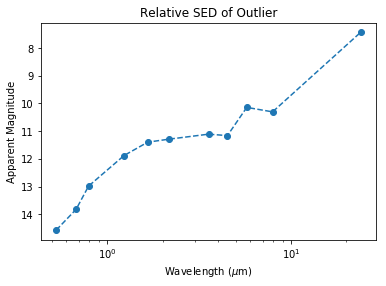

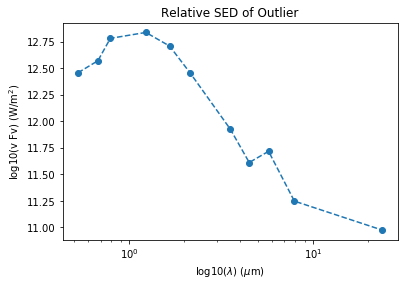

[ 0.00502918  0.00837314  0.01590541  0.02818957  0.02825531  0.02028596
  0.00997     0.00614     0.00997     0.00468     0.00751   ]
[  5.67939336e+14   4.42583017e+14   3.78568850e+14   2.42746930e+14
   1.80380540e+14   1.38857090e+14   8.42762289e+13   6.65476396e+13
   5.22416661e+13   3.78173919e+13   1.25734413e+13]
[  2.85626999e+12   3.70580760e+12   6.02129270e+12   6.84293051e+12
   5.09670878e+12   2.81685007e+12   8.40234002e+11   4.08602507e+11
   5.20849411e+11   1.76985394e+11   9.44265439e+10]


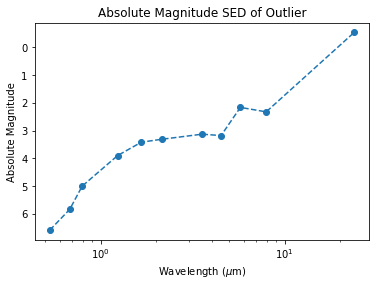

In [40]:
condition = pmmagYSO_Reg2>30
pmmag = pmmagYSO_Reg2[np.where(pmmagYSO_Reg2 >30)]
print('The proper motion magnitude is',pmmag,' km/s')
CheckOutlier(condition, identifiers_Reg2,YSO_match,c2dYSO_match,GTab,Gdist,GBYSO)

In [ ]:
YSO_Reg3_properties, YSO_Reg3_values = CalculateProperties('YSO_Reg3',YSO_match,Gvalues,\
                                                           distance_range=[350.,550.],\
                                                           sky_region = [ra_min3,ra_max3,dec_min3,dec_max3])

raYSO_Reg3 = YSO_Reg3_properties[0][:]
decYSO_Reg3 = YSO_Reg3_properties[1][:]
pmraYSO_Reg3 = YSO_Reg3_properties[2][:]
pmdecYSO_Reg3 = YSO_Reg3_properties[3][:]
pmra_eYSO_Reg3 = YSO_Reg3_properties[4][:]
pmdec_eYSO_Reg3 = YSO_Reg3_properties[5][:]
parYSO_Reg3 = YSO_Reg3_properties[6][:]
par_snYSO_Reg3 = YSO_Reg3_properties[7][:]
distYSO_Reg3 = YSO_Reg3_properties[8][:]
pmra_kmYSO_Reg3 = YSO_Reg3_properties[9][:]
pmdec_kmYSO_Reg3 = YSO_Reg3_properties[10][:]
rpmraYSO_Reg3 = YSO_Reg3_properties[11][:]
rpmdecYSO_Reg3 = YSO_Reg3_properties[12][:]
pmmagYSO_Reg3 = YSO_Reg3_properties[13][:]
parsn10YSO_Reg3 = YSO_Reg3_properties[14][:]
parsn5YSO_Reg3 = YSO_Reg3_properties[15][:]
parsn10YSO_Reg3 = YSO_Reg3_properties[16][:]
mean_pmraYSO_Reg3 = YSO_Reg3_values[0]
mean_pmdecYSO_Reg3 = YSO_Reg3_values[1]
median_pmraYSO_Reg3 = YSO_Reg3_values[2]
median_pmdecYSO_Reg3 = YSO_Reg3_values[3]

In [ ]:
#determine high proper motion YSOs 
high_pmYSO = pmmagYSO[parsn5YSO] > 8.
for i in range(0,len(high_pmYSO)):
    if(high_pmYSO[i]):
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i])

In [ ]:
#FIXED determine high proper motion YSOs
for i in range(0,len(pmmagYSO)):
    if(pmmagYSO[i] > 8): 
        j = YSO_match[i] #identifier of YSO match
        print(Gra[j],Gdec[j],c2dYSOobj[i],rpmraYSO[i],rpmdecYSO[i],pmmagYSO[i],par_snYSO[i])
        #figure out difference between i and j

In [ ]:
print(len(YSO_match))
print(len(high_pmYSO))

In [ ]:
#define variables
ra_big = GTab["ra"]
dec_big = GTab["dec"]
par_big = GTab["parallax"]
pare_big = GTab["parallax_error"]
parsn_big = GTab["parallax_over_error"]
pmra_big = GTab["pmra"]
pmdec_big = GTab["pmdec"]
print(len(ra_big))

#count number of sources in distance range
nn = 0
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if(dist > 350. and dist <550. and parsn_big[i]>10.):
         nn = nn + 1
print("Number of sources in distance range:", nn)


secperyr = 60*60*24*365.25
to_kms = 443./1000. * 1.496e8/secperyr

#find magnitude of proper motion for sources with S/N greater than 10 in parallax
pm_mag = np.zeros(0)
for i in range(0,len(ra_big)):
     dist = 1000/par_big[i]
     if (dist > 350. and dist <550. and parsn_big[i]>10.):
        
        pmra_km = (pmra_big[i]*dist*const.au.value)/(secperyr*1000.0)
        pmdec_km = (pmdec_big[i]*dist*const.au.value)/(secperyr*1000.0)
        #pm2 = pmra_big[i]*pmra_big[i] + pmdec_big[i]*pmdec_big[i]
        pm2 = pmra_km*pmra_km+pmdec_km*pmdec_km
        pm = np.power(pm2,0.5)
        pm_mag = np.append(pm_mag,pm)
        
print(len(pm_mag))

#create histogram of number of sources for each proper motion magnitude
plt.hist(pm_mag,bins=100)
plt.xlabel("Magnitude of Proper Motion (km/sec)")
plt.ylabel("Number of sources with S/N>10 in Parallax")
plt.text(100000,300,"Gaia sources in 5 deg radius of (18:30, -1 deg)")
plt.text(100000,250,"With Parallax S/N > 10")
plt.text(100000,200,"With 350 pc < Dist < 550 pc")
plt.savefig("big-Serp-pms.png")
plt.show()

# WISE Data

In [ ]:
WISE_YSO = Table.read('WISE_SVM_YSO_class1+2.vot',format='votable')
print(WISE_YSO.colnames)
Wra = WISE_YSO['RAJ2000']
Wdec = WISE_YSO['DEJ2000']

In [ ]:
#match up GAIA catalog and WISE YSO catalog
WISE_YSO2MASS = WISE_YSO['_2MASSKey']
WISE_YSO_match = np.empty(len(WISE_YSO2MASS),dtype=int)
WISE_YSO_match.fill(-2)
for j in range(0,len(WISE_YSO2MASS)):
    if(WISE_YSO2MASS[j] in gaia_list):
        WISE_YSO_match[j] = gaia_list.index(WISE_YSO2MASS[j])
    else:
        WISE_YSO_match[j] = -2
good_WISE_YSO = WISE_YSO_match > -1
print(len(WISE_YSO_match[good_WISE_YSO]))
print(np.where(WISE_YSO_match > -1))

In [ ]:
#matching the catalogs 

gaia_coord = SkyCoord(ra=Gra,dec=Gdec,unit=(u.deg,u.deg))
WISE_coord = SkyCoord(ra=Wra,dec=Wdec,unit=(u.deg,u.deg))
idx, d2d, d3d = WISE_coord.match_to_catalog_sky(gaia_coord)

In [ ]:
#match up GAIA catalog with WISE catalog

for j in range(0,len(WISE_match)):
    if(d3d[i] = np.mean(d3d)):
        WISE_match[j] = gaia_list.index(GBYSO2MASS[j])
    else:
        GBYSO_match[j] = -2
good_GBYSO = GBYSO_match > -1
print(len(GBYSO_match[good_GBYSO]))
print(np.where(GBYSO_match > -1))

In [ ]:
WISE_match = np.empty(len(Wra),dtype=int); WISE_match.fill(-2)
for i in range(len(d2d)):
    if (d2d[i] <= Angle('0d00m00.2s')):
        WISE_match[i] = idx[i]
    else:
        WISE_match[i] = -2
good_WISE_YSO = WISE_match >-1
print(len(WISE_match[good_WISE_YSO]))
print(np.where(WISE_match > -1))

In [ ]:
for i in range(len(c2dYSO_match)):
    if()

In [ ]:
#Failed method to get WISE data

mydec = -1.00
myra = 277.49

from astroquery.irsa import Irsa
Irsa.ROW_LIMIT = 10000 #value of new row limit here
Irsa.list_catalogs()
irsatable = Irsa.query_region(SkyCoord(myra,mydec,unit=(u.deg,u.deg),frame='icrs'),catalog='allwise_p3as_psd',\
                              spatial='Box',width=5*u.deg)
print(irsatable['designation','ra','dec','w3mpro','w3sigmpro','id'])